### Data Analysis Setup

This initial stage establishes the foundation for analysing conflict event data using the ACLED dataset, with a primary focus on Eastern Europe.

**Summary of actions:**
- A set of 13 European countries was defined, spanning three regions, to guide the geographic focus of the analysis.
- The full ACLED dataset for Europe and Central Asia (2018–2025) was loaded, and preliminary checks were conducted to assess its structure, coverage, and memory footprint.

**Initial observations:**
- The dataset contains **527,211 records** spanning from **2018 to 2025**.
- All records include non-null entries in the `notes` field, which is beneficial for subsequent text-based analysis.
- While the study primarily focuses on Eastern Europe, it also includes countries from Central Europe and the Baltic region for broader comparative context.

**Relevance to the study:**
This setup phase ensures a consistent and well-defined regional scope, while confirming the dataset’s suitability for both quantitative and qualitative analysis of conflict events.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [2]:
# Analysis parameters
QUALITY_CONFIG = {
    'min_length': 30,
    'min_words': 5,
    'detailed_min_length': 50,
    'sample_size': 10
}

GEOGRAPHIC_CONFIG = {
    'Eastern_Europe': ['Ukraine', 'Russia', 'Belarus', 'Moldova', 'Bulgaria', 'Romania'],
    'Central_Europe': ['Poland', 'Czech Republic', 'Hungary', 'Slovakia'],
    'Baltic_States': ['Lithuania', 'Latvia', 'Estonia'],
}

# Flatten list of target countries
ALL_TARGET_COUNTRIES = [country for region in GEOGRAPHIC_CONFIG.values() for country in region]

# Visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("ACLED DATASET ANALYSIS:")

# Load dataset
try:
    df = pd.read_csv('Europe-Central-Asia_2018-2025_July.csv')
    print(f"Records loaded: {len(df):,}")
    print(f"Date range: {df['event_date'].min()} to {df['event_date'].max()}")
    print(f"Notes present: {df['notes'].notna().sum():,} ({df['notes'].notna().mean()*100:.1f}%)")
except FileNotFoundError:
    print("ERROR: 'Europe-Central-Asia_2018-2025_July.csv' not found in the working directory.")
    df = None

ACLED DATASET ANALYSIS:
Records loaded: 527,211
Date range: 2018-01-01 to 2025-07-04
Notes present: 527,211 (100.0%)


### Filtering for Eastern European Countries

At this stage, the dataset was filtered to retain only records corresponding to the 13 countries of interest, as defined in the regional configuration.

**Actions taken:**
- The full dataset of 527,211 records was filtered to include only events occurring within the target countries.
- These countries were grouped into three regional categories:
  - **Eastern Europe**: Ukraine, Russia, Belarus, Romania, Moldova, Bulgaria  
  - **Central Europe**: Poland, Czech Republic, Hungary, Slovakia  
  - **Baltic States**: Lithuania, Latvia, Estonia
- The `event_date` column was converted to a datetime format to support later temporal analysis.

**Key results:**
- The filtered dataset contains **309,974 events**, representing **58.8%** of the original dataset.
- All 13 target countries are represented in the filtered subset.
- The temporal range remains consistent, spanning from **2018 to 2025**.

**Relevance to the study:**
Focusing on these countries enables a more targeted analysis aligned with the study’s geographic scope. The regional classification provides an additional layer for comparative analysis across different parts of Eastern Europe and its neighbouring regions.

In [3]:
print("EASTERN EUROPE SUBSET & OTHER COUNTRIES OF INTEREST:")

# Display regional groupings
for region, countries in GEOGRAPHIC_CONFIG.items():
    print(f"{region.replace('_', ' ').title()}: {', '.join(countries)}")

# Filter records
eastern_europe_df = df[df['country'].isin(ALL_TARGET_COUNTRIES)].copy()
eastern_europe_df['event_date'] = pd.to_datetime(eastern_europe_df['event_date'])
eastern_europe_df['year'] = eastern_europe_df['event_date'].dt.year

# Assign regional labels
def get_region(country):
    for region, group in GEOGRAPHIC_CONFIG.items():
        if country in group:
            return region.replace('_', ' ').title()
    return 'Other'

eastern_europe_df['region'] = eastern_europe_df['country'].apply(get_region)

# Display summary
print("\nFiltering Results:")
print(f"Records retained: {len(eastern_europe_df):,} ({len(eastern_europe_df)/len(df)*100:.1f}%)")
print(f"Countries represented: {eastern_europe_df['country'].nunique()}/{len(ALL_TARGET_COUNTRIES)}")
print(f"Temporal span: {eastern_europe_df['year'].min()}–{eastern_europe_df['year'].max()}")

# Check for missing countries
missing = set(ALL_TARGET_COUNTRIES) - set(eastern_europe_df['country'].unique())
if missing:
    print(f"Missing countries: {', '.join(sorted(missing))}")
else:
    print("All target countries are represented.")

EASTERN EUROPE SUBSET & OTHER COUNTRIES OF INTEREST:
Eastern Europe: Ukraine, Russia, Belarus, Moldova, Bulgaria, Romania
Central Europe: Poland, Czech Republic, Hungary, Slovakia
Baltic States: Lithuania, Latvia, Estonia

Filtering Results:
Records retained: 309,974 (58.8%)
Countries represented: 13/13
Temporal span: 2018–2025
All target countries are represented.


### Distribution of Conflict Events by Country and Region

During this particular stage of the analysis, we examine how conflict events are distributed across the target countries, revealing significant geographic imbalances.

**Key findings:**
- **Ukraine accounts for the vast majority of events**, with 243,794 records (78.6% of all events in the filtered dataset).
- **Russia follows**, with 39,280 events (12.7%).
- **Other countries contribute comparatively few events**, with Poland being the highest among them at 8,231 events.

**Regional distribution:**
- **Eastern Europe**: 95.7% of all events (dominated by Ukraine and Russia)
- **Central Europe**: 3.9%
- **Baltic States**: 0.4%

**Relevance to the study:**
This concentration of data in Ukraine and Russia has direct implications for the analytical and modelling components of the research:
- It provides a substantial volume of data for in-depth analysis in the Eastern European core.
- However, it also introduces a risk of geographic bias, particularly in model training or comparative studies.
- As such, sampling strategies or weighting adjustments may be required to ensure that less-represented countries are not overlooked in the analysis.

COUNTRY DISTRIBUTION ANALYSIS:
Country Summary:
                        Region Total_Events Events_with_Notes Note_Coverage
country                                                                    
Ukraine         Eastern Europe      243,794           243,794        100.0%
Russia          Eastern Europe       39,280            39,280        100.0%
Poland          Central Europe        8,231             8,231        100.0%
Bulgaria        Eastern Europe        4,430             4,430        100.0%
Belarus         Eastern Europe        4,085             4,085        100.0%
Romania         Eastern Europe        3,101             3,101        100.0%
Moldova         Eastern Europe        2,013             2,013        100.0%
Czech Republic  Central Europe        1,509             1,509        100.0%
Hungary         Central Europe        1,273             1,273        100.0%
Slovakia        Central Europe        1,046             1,046        100.0%
Lithuania        Baltic States          

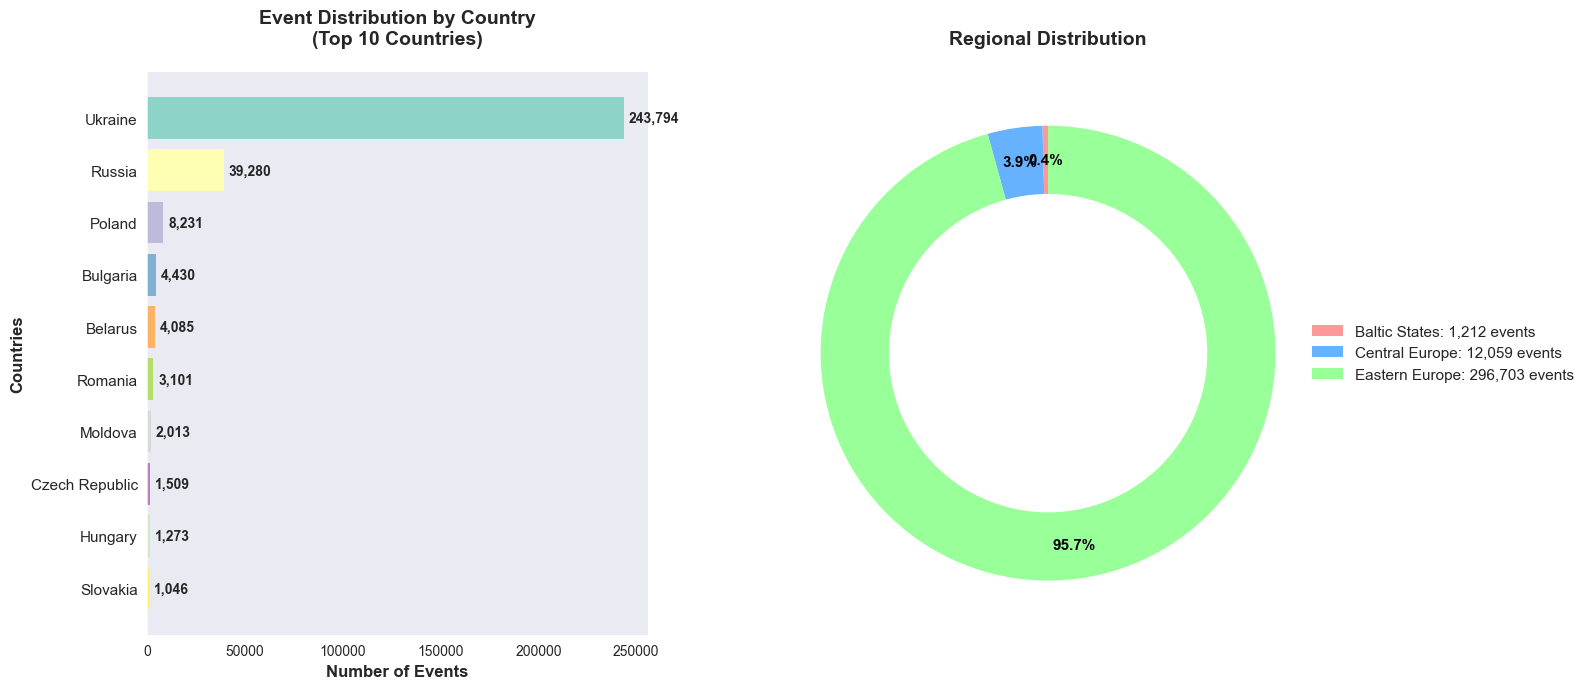

SUMMARY STATISTICS:
Total Countries: 13
Total Events: 309,974
Average Events per Country: 23844
Top Country Share: 78.6%
Top 3 Countries Share: 94.0%


In [4]:
def analyse_country_distribution():
    "Analyse geographic distribution with regional context"
    
    print("COUNTRY DISTRIBUTION ANALYSIS:")
    
    # Country-level statistics
    country_stats = eastern_europe_df.groupby('country').agg({
        'event_date': 'count',
        'notes': lambda x: x.notna().sum(),
        'year': ['min', 'max']
    }).round(0)
    
    country_stats.columns = ['Total_Events', 'Events_with_Notes', 'First_Year', 'Last_Year']
    country_stats['Note_Coverage'] = (country_stats['Events_with_Notes'] / 
                                     country_stats['Total_Events'] * 100).round(1)
    
    # Regional information
    country_stats['Region'] = [get_region(country) for country in country_stats.index]
    country_stats = country_stats.sort_values('Total_Events', ascending=False)
    
    print("Country Summary:")
    display_cols = ['Region', 'Total_Events', 'Events_with_Notes', 'Note_Coverage']
    print(country_stats[display_cols].to_string(formatters={
        'Total_Events': '{:,}'.format,
        'Events_with_Notes': '{:,}'.format,
        'Note_Coverage': '{:.1f}%'.format
    }))
    
    # Regional aggregation
    regional_stats = country_stats.groupby('Region').agg({
        'Total_Events': 'sum',
        'Events_with_Notes': 'sum'
    })
    regional_stats['Percentage'] = (regional_stats['Total_Events'] / 
                                   regional_stats['Total_Events'].sum() * 100).round(1)
    
    print(f"\nRegional Distribution:")
    for region, row in regional_stats.iterrows():
        print(f"{region}: {row['Total_Events']:,} events ({row['Percentage']:.1f}%)")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Country distribution
    top_10 = country_stats.head(10)
    colours = plt.cm.Set3(np.linspace(0, 1, len(top_10)))
    
    bars = ax1.barh(range(len(top_10)), top_10['Total_Events'], color=colours)
    ax1.set_title('Event Distribution by Country\n(Top 10 Countries)', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Number of Events', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Countries', fontsize=12, fontweight='bold')
    ax1.set_yticks(range(len(top_10)))
    ax1.set_yticklabels(top_10.index, fontsize=11)
    ax1.invert_yaxis()
    
    # Value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_10['Total_Events'])):
        ax1.text(value + max(top_10['Total_Events']) * 0.01, i, f'{value:,}', 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    ax1.grid(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(0.5)
    ax1.spines['bottom'].set_linewidth(0.5)
    
    # Regional distribution
    regional_values = regional_stats['Total_Events']
    regional_labels = regional_stats.index
    regional_colours = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'][:len(regional_values)]
    
    # Doughnut chart
    wedges, texts, autotexts = ax2.pie(regional_values, 
                                       labels=None,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=regional_colours,
                                       pctdistance=0.85,
                                       wedgeprops=dict(width=0.5))
    
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)
    
    ax2.set_title('Regional Distribution', fontsize=14, fontweight='bold', pad=20)
    
    legend_labels = [f'{label}: {value:,} events' for label, value in zip(regional_labels, regional_values)]
    ax2.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), 
              fontsize=11, frameon=False)
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    ax2.axis('equal')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

    print("SUMMARY STATISTICS:")
    print(f"Total Countries: {len(country_stats)}")
    print(f"Total Events: {country_stats['Total_Events'].sum():,}")
    print(f"Average Events per Country: {country_stats['Total_Events'].mean():.0f}")
    print(f"Top Country Share: {country_stats.iloc[0]['Total_Events']/country_stats['Total_Events'].sum()*100:.1f}%")
    print(f"Top 3 Countries Share: {country_stats.head(3)['Total_Events'].sum()/country_stats['Total_Events'].sum()*100:.1f}%")
    
    return country_stats, regional_stats

country_distribution, regional_distribution = analyse_country_distribution()

### Filtering Out Low-Quality Notes

Before conducting in-depth textual analysis, an initial quality control step was applied to determine which narrative notes were suitable for information extraction.

**Quality criteria applied (conservative threshold):**

1. **Minimum length**: At least 30 characters, to exclude trivial or incomplete entries
2. **Minimum word count**: At least 5 words, to ensure the presence of meaningful content
3. **Placeholder removal**: Any notes containing test data or placeholder text were excluded
4. **Punctuation requirement**: Notes must contain at least one punctuation mark, indicating syntactic coherence

**Filtering outcomes:**

- Initial sample size: **309,974 notes**
- Notes meeting quality criteria: **276,856**
- **Pass rate**: **89.3%**

**Rejection breakdown:**
- **Test/placeholder content**: 33,118 notes (10.68%) - entries containing test data or placeholder text
- **Other quality issues**: Minor rejections for length, word count, or punctuation requirements

**Interpretation:**
The ACLED dataset demonstrates generally strong quality in its narrative fields, with nearly 9 out of 10 entries meeting the minimum standards required for analysis. The primary quality issue identified was the presence of test or placeholder content, accounting for the majority of rejections. This suggests robust data collection processes, with quality control issues primarily stemming from administrative entries rather than poor reporting standards.

**Data characteristics:**
- **Average note length**: 187 characters
- **Average word count**: 28 words
- **Length distribution**: Notes range from 62 to 2,225 characters, with median length of 139 characters
- **Quality consistency**: The 89.3% pass rate indicates reliable content standards across the dataset

In [5]:
def basic_quality_assessment():
    "Apply simple, conservative quality filters"
    
    print("\nQUALITY ASSESSMENT:")
    
    notes_df = eastern_europe_df[eastern_europe_df['notes'].notna()].copy()
    notes_df['note_length'] = notes_df['notes'].str.len()
    notes_df['word_count'] = notes_df['notes'].str.split().str.len()
    
    print(f"Notes available for assessment: {len(notes_df):,}")
    print(f"Average length: {notes_df['note_length'].mean():.0f} characters")
    print(f"Average words: {notes_df['word_count'].mean():.0f} words")
    
    def basic_quality_filter(note):
        "Conservative quality filter for initial screening"
        text = str(note).strip()
        text_lower = text.lower()
        
        # Filter 1: Minimum length
        if len(text) < QUALITY_CONFIG['min_length']:
            return False, "too_short"
        
        # Filter 2: Minimum word count
        if len(text.split()) < QUALITY_CONFIG['min_words']:
            return False, "insufficient_words"
        
        # Filter 3: Test entries
        if any(term in text_lower for term in ['test', 'example', 'lorem ipsum']):
            return False, "test_entry"
        
        # Filter 4: Basic content check
        if text.count('.') == 0 and text.count(',') == 0:
            return False, "no_punctuation"
        
        return True, "passed"
    
    # Applying quality filters
    print(f"\nApplying quality filters")
    basic_results = []
    basic_reasons = []
    rejected_examples = {}  # Store examples for each rejection reason
    
    for note in notes_df['notes']:
        passed, reason = basic_quality_filter(note)
        basic_results.append(passed)
        basic_reasons.append(reason)
        
        # Collect examples of rejected notes
        if not passed and reason not in rejected_examples:
            rejected_examples[reason] = str(note)[:100] + "..." if len(str(note)) > 100 else str(note)
    
    notes_df['basic_quality'] = basic_results
    notes_df['filter_reason'] = basic_reasons
    
    total_notes = len(notes_df)
    basic_pass = sum(basic_results)
    basic_rate = (basic_pass / total_notes) * 100
    
    print(f"Filter Results:")
    print(f"Total notes processed: {total_notes:,}")
    print(f"Notes passing filters: {basic_pass:,}")
    print(f"Pass rate: {basic_rate:.1f}%")
    
    # Detailed rejection analysis with examples
    rejection_counts = Counter(basic_reasons)
    print(f"\nRejection Analysis:")
    
    # Descriptions for rejection reasons
    rejection_descriptions = {
        'too_short': f'Text shorter than {QUALITY_CONFIG["min_length"]} characters',
        'insufficient_words': f'Fewer than {QUALITY_CONFIG["min_words"]} words',
        'test_entry': 'Contains test/placeholder content',
        'no_punctuation': 'Missing basic punctuation (no periods or commas)'
    }
    
    for reason, count in rejection_counts.items():
        if reason != "passed":
            pct = (count / total_notes) * 100
            description = rejection_descriptions.get(reason, reason.replace('_', ' ').title())
            
            print(f"{description}")
            print(f"Count: {count:,} ({pct:.2f}%)")
            
            if reason in rejected_examples:
                print(f"Example: \"{rejected_examples[reason]}\"")
            print()  # Empty line for separation
    
    print(f"Note Length Distribution:")
    print(f"Minimum: {notes_df['note_length'].min()} characters")
    print(f"25th percentile: {notes_df['note_length'].quantile(0.25):.0f} characters")
    print(f"Median: {notes_df['note_length'].median():.0f} characters")
    print(f"75th percentile: {notes_df['note_length'].quantile(0.75):.0f} characters")
    print(f"Maximum: {notes_df['note_length'].max()} characters")
    
    return notes_df

notes_quality_df = basic_quality_assessment()


QUALITY ASSESSMENT:
Notes available for assessment: 309,974
Average length: 187 characters
Average words: 28 words

Applying quality filters
Filter Results:
Total notes processed: 309,974
Notes passing filters: 276,856
Pass rate: 89.3%

Rejection Analysis:
Contains test/placeholder content
Count: 33,118 (10.68%)
Example: "On 4 July 2025, protesters and supporters of the Revival party protested in front of the national as..."

Note Length Distribution:
Minimum: 62 characters
25th percentile: 108 characters
Median: 139 characters
75th percentile: 216 characters
Maximum: 2225 characters


### Quality Patterns Across Countries

Certain countries contribute significantly more high-quality narrative notes than others, with substantial variation in pass rates and note characteristics.

**Key findings:**
- **Ukraine** provides the largest share, with 239,536 quality notes and a 98.0% pass rate.
- **Russia** follows with 31,716 quality notes (81.0%).
- Pass rates vary widely, from 98.0% (Ukraine) to just 9.0% (Bulgaria).
- Average note lengths and word counts also differ, reflecting differences in reporting style or source detail.

**Quality rate distribution:**
- **High performers**: Ukraine (98.0%), Russia (81.0%), Slovakia (42.0%), Czech Republic (40.0%)
- **Moderate**: Poland (30.0%), Moldova (21.0%), Estonia (21.0%)
- **Lower performers**: Belarus (16.0%), Lithuania (15.0%), Latvia (13.0%), Hungary (12.0%), Romania (10.0%), Bulgaria (9.0%)

**Sample coverage for research:**
- 1,000 samples: Achievable (27,686% coverage)
- 5,000 samples: Achievable (5,537% coverage)
- 10,000 samples: Achievable (2,769% coverage)

**Countries meeting a 100-note threshold:**
10 out of 13 target countries meet this benchmark. Estonia (85), Lithuania (78), and Latvia (38) fall slightly short.

**Note characteristics:**
- **Longest notes** (by character length): Russia (293), Lithuania (267)
- **Shortest**: Ukraine (166), Belarus (160)
- **Word count**: Russia averages 44 words per note; Ukraine averages 24

**Implications:**
- The dataset contains 276,856 high-quality notes, more than sufficient for large-scale research.
- Ukraine and Russia account for 98.0% of the total, which introduces significant geographic concentration.
- Quality disparities suggest that reporting standards or practices may differ by country.
- Strategic sampling will be necessary to achieve regional balance while maintaining data quality.

**Research strategy considerations:**
- Ukraine offers exceptional coverage for detailed studies.
- Balanced regional or comparative analyses will require additional controls for quality and representation.
- Where possible, sampling strategies should prioritise both geographic and structural diversity within the notes.


COUNTRY QUALITY ANALYSIS:
Country Quality Statistics:
               Total_Notes Quality_Notes Quality_Rate Avg_Length Avg_Words
country                                                                   
Ukraine            243,794       239,536        98.0%        166        24
Russia              39,280        31,716        81.0%        293        44
Poland               8,231         2,429        30.0%        213        33
Belarus              4,085           657        16.0%        160        25
Czech Republic       1,509           611        40.0%        220        34
Slovakia             1,046           444        42.0%        246        37
Moldova              2,013           414        21.0%        226        35
Bulgaria             4,430           392         9.0%        260        42
Romania              3,101           302        10.0%        196        30
Hungary              1,273           154        12.0%        245        38
Estonia                404            85     

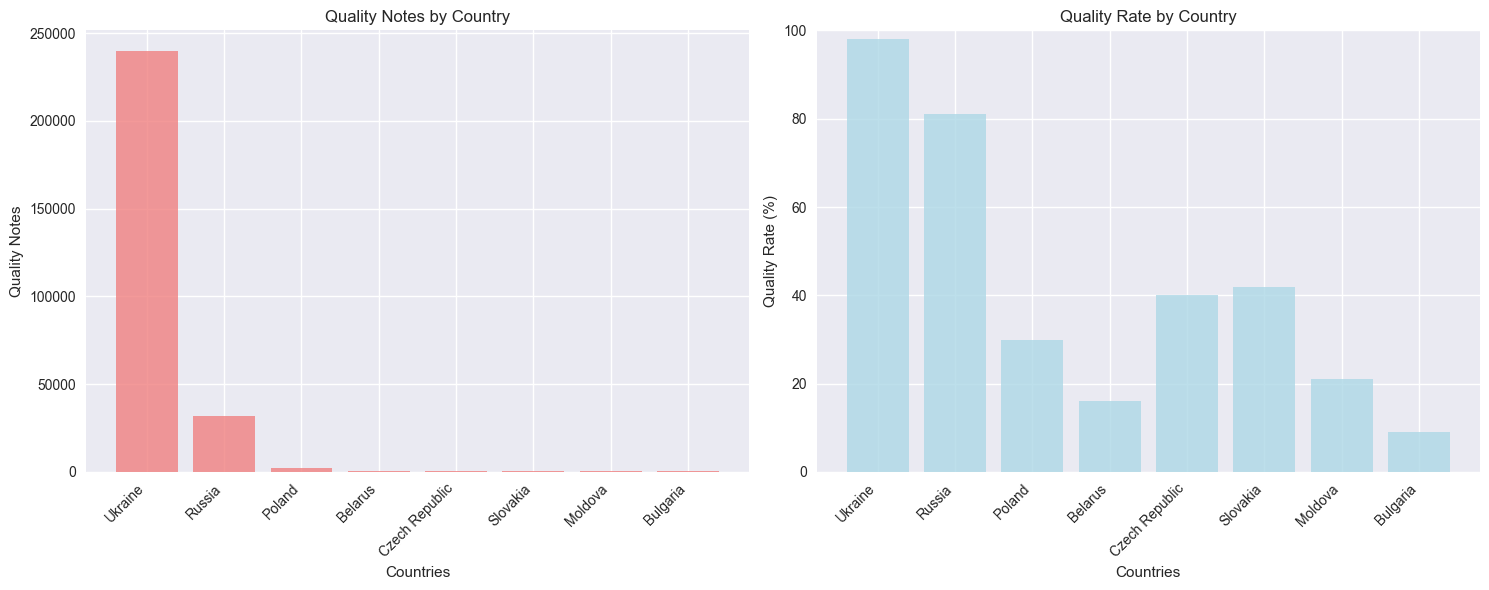

In [6]:
def analyse_country_quality():
    "Examine quality patterns across countries"
    
    print("\nCOUNTRY QUALITY ANALYSIS:")
    
    global notes_quality_df
    
    # Check if notes_quality_df is registered; if not, run the basic quality assessment.
    try:
        test = notes_quality_df['basic_quality']
    except (NameError, KeyError):
        print("Running basic quality assessment first")
        notes_quality_df = basic_quality_assessment()
    
    # Country-level quality statistics
    country_quality = notes_quality_df.groupby('country').agg({
        'basic_quality': ['count', 'sum', 'mean'],
        'note_length': 'mean',
        'word_count': 'mean'
    }).round(2)
    
    country_quality.columns = ['Total_Notes', 'Quality_Notes', 'Quality_Rate', 
                              'Avg_Length', 'Avg_Words']
    country_quality = country_quality.sort_values('Quality_Notes', ascending=False)
    
    print("Country Quality Statistics:")
    print(country_quality.to_string(formatters={
        'Total_Notes': '{:,.0f}'.format,
        'Quality_Notes': '{:,.0f}'.format,
        'Quality_Rate': '{:.1%}'.format,
        'Avg_Length': '{:.0f}'.format,
        'Avg_Words': '{:.0f}'.format
    }))
    
    # Research feasibility
    total_quality = country_quality['Quality_Notes'].sum()
    targets = [1000, 5000, 10000]
    
    print(f"\nResearch Feasibility:")
    print(f"Total quality notes available: {total_quality:,}")
    for target in targets:
        status = "ACHIEVABLE" if total_quality >= target else "INSUFFICIENT"
        coverage = (total_quality / target) * 100 if total_quality >= target else (total_quality / target) * 100
        print(f"{target:,} sample target: {status} ({coverage:.0f}% coverage)")
    
    # Countries with substantial data
    substantial_threshold = 100
    substantial_countries = country_quality[country_quality['Quality_Notes'] >= substantial_threshold]
    
    print(f"\nCountries with Substantial Data (≥{substantial_threshold} quality notes):")
    for country, row in substantial_countries.iterrows():
        print(f"{country}: {row['Quality_Notes']:,.0f} notes ({row['Quality_Rate']:.1%} rate)")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Quality notes by country
    top_8 = country_quality.head(8)
    ax1.bar(range(len(top_8)), top_8['Quality_Notes'], color='lightcoral', alpha=0.8)
    ax1.set_title('Quality Notes by Country')
    ax1.set_xlabel('Countries')
    ax1.set_ylabel('Quality Notes')
    ax1.set_xticks(range(len(top_8)))
    ax1.set_xticklabels(top_8.index, rotation=45, ha='right')
    
    # Quality rates
    ax2.bar(range(len(top_8)), top_8['Quality_Rate'] * 100, color='lightblue', alpha=0.8)
    ax2.set_title('Quality Rate by Country')
    ax2.set_xlabel('Countries')
    ax2.set_ylabel('Quality Rate (%)')
    ax2.set_xticks(range(len(top_8)))
    ax2.set_xticklabels(top_8.index, rotation=45, ha='right')
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    return country_quality

country_quality_stats = analyse_country_quality()

### Deep Dive into Note Quality

Moving beyond basic filters, we're now scoring each note on a 10-point scale based on how useful it would be for structured data extraction.

**My detailed scoring criteria:**
- **Length (0-2 points)**: Longer notes generally contain more information
- **Content richness (0-2 points)**: More words suggest more detailed descriptions
- **Event indicators (0-2 points)**: Presence of conflict-related keywords
- **Geographic context (0-2 points)**: Mentions of specific places/locations
- **Temporal markers (0-1 point)**: Time references that help with dating
- **Source attribution (0-1 point)**: Mentions of sources or officials

**Detailed scoring results:**
- **Average score**: 6.4/10 (strong quality overall)
- **Score range**: 2-10 (high-quality spectrum, with no notes scoring below 2)
- **High-quality notes (≥6 points)**: 218,050 notes (78.8% of all notes)

**Country performance by average quality score:**
- **Russia leads**: 7.0/10 average (highest quality notes despite lower volume)
- **Smaller countries excel**: Moldova (6.8), Belarus (6.7), Slovakia (6.6) show strong performance
- **Consistent quality**: All countries score above 6.0, indicating reliable reporting standards
- **Ukraine**: 6.3/10 average (solid quality with massive volume - 239,536 notes)

**Regional patterns:**
The quality scores demonstrate remarkably consistent standards across all countries, with even the lowest-scoring country (Ukraine) maintaining a solid 6.3/10 average. This suggests robust editorial and reporting practices across the ACLED network.

**What this means:**
Nearly 4 out of 5 notes (78.8%) score 6 or higher, indicating they contain rich, structured information ideal for data extraction. Combined with the high minimum score of 2/10, this dataset provides an exceptional foundation for building sophisticated extraction models with confidence in data quality.


DETAILED QUALITY SCORING:
Notes for detailed scoring: 276,856
Detailed Scoring Results:
Average score: 6.4/10
Score range: 2 - 10
High-quality notes (≥6): 218,050 (78.8%)

Detailed Scores by Country (Top 8):
                 Count  Avg_Score
country                          
Ukraine         239536        6.3
Russia           31716        7.0
Poland            2429        6.5
Belarus            657        6.7
Czech Republic     611        6.5
Slovakia           444        6.6
Moldova            414        6.8
Bulgaria           392        6.9


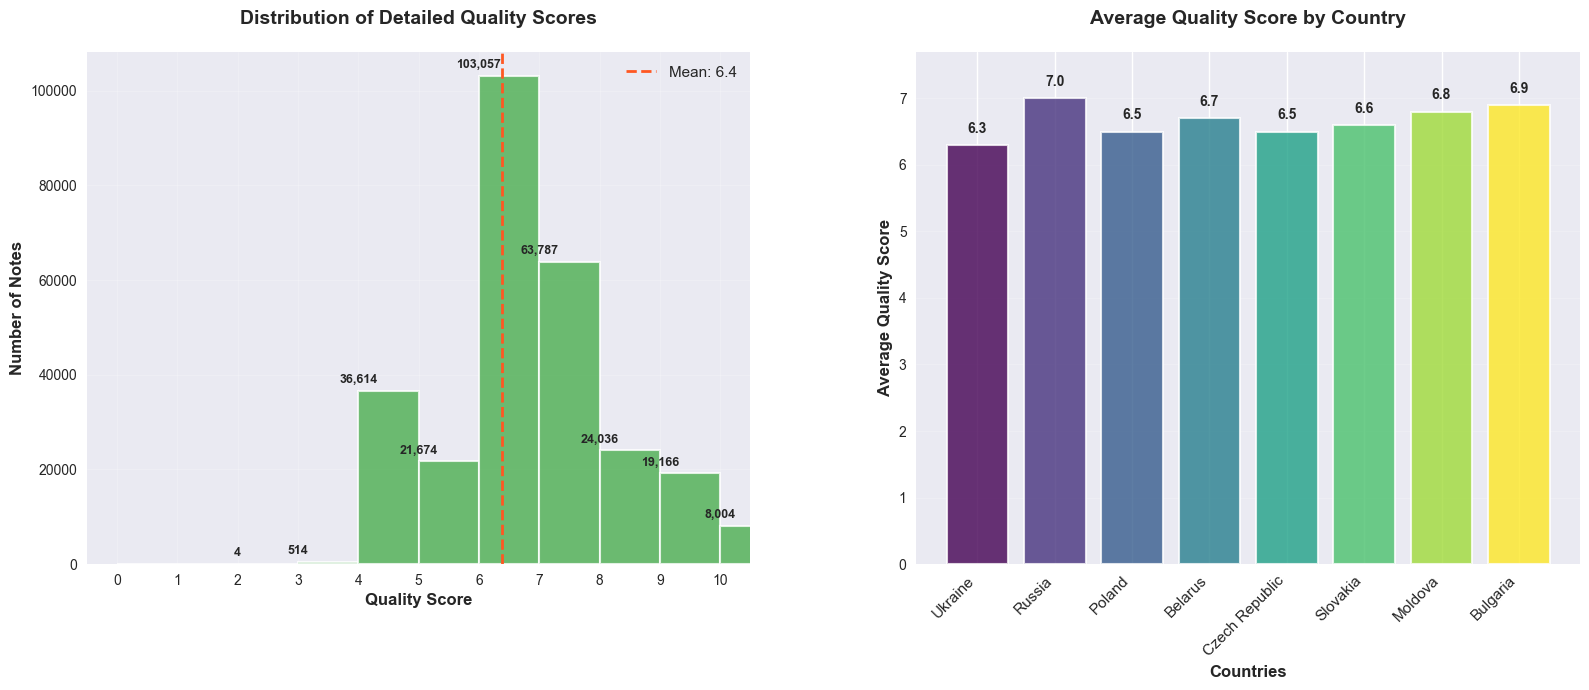

In [7]:
def detailed_quality_scoring():
    "Apply detailed scoring to notes that passed basic filters"
    
    print("\nDETAILED QUALITY SCORING:")
    
    # Working with notes that passed basic filters
    quality_notes = notes_quality_df[notes_quality_df['basic_quality'] == True].copy()
    
    print(f"Notes for detailed scoring: {len(quality_notes):,}")
    
    def calculate_quality_score(note):
        "Calculate detailed quality score (0-10 scale)"
        text = str(note).strip()
        text_lower = text.lower()
        score = 0
        
        # Length component (0-2 points)
        if len(text) >= 50:
            score += 1
        if len(text) >= 100:
            score += 1
        
        # Content richness (0-2 points)
        words = text.split()
        if len(words) >= 15:
            score += 1
        if len(words) >= 25:
            score += 1
        
        # Event indicators (0-2 points)
        event_terms = ['killed', 'injured', 'attack', 'explosion', 'protest', 'clash']
        event_count = sum(1 for term in event_terms if term in text_lower)
        score += min(event_count, 2)
        
        # Geographic context (0-2 points)
        proper_nouns = len(re.findall(r'\b[A-Z][a-z]{3,}\b', text))
        if proper_nouns >= 2:
            score += 1
        if proper_nouns >= 4:
            score += 1
        
        # Temporal markers (0-1 point)
        temporal_terms = ['20', 'today', 'yesterday', 'during']
        if any(term in text for term in temporal_terms):
            score += 1
        
        # Source attribution (0-1 point)
        source_terms = ['according', 'reported', 'officials']
        if any(term in text_lower for term in source_terms):
            score += 1
        
        return score
    
    quality_notes['detailed_score'] = quality_notes['notes'].apply(calculate_quality_score)
    
    print(f"Detailed Scoring Results:")
    print(f"Average score: {quality_notes['detailed_score'].mean():.1f}/10")
    print(f"Score range: {quality_notes['detailed_score'].min():.0f} - {quality_notes['detailed_score'].max():.0f}")
    
    # High-quality subset (score ≥ 6)
    high_quality = quality_notes[quality_notes['detailed_score'] >= 6]
    print(f"High-quality notes (≥6): {len(high_quality):,} ({len(high_quality)/len(quality_notes)*100:.1f}%)")
    
    # Score distribution by country
    country_scores = quality_notes.groupby('country')['detailed_score'].agg(['count', 'mean']).round(1)
    country_scores.columns = ['Count', 'Avg_Score']
    country_scores = country_scores.sort_values('Count', ascending=False)
    
    print(f"\nDetailed Scores by Country (Top 8):")
    print(country_scores.head(8).to_string())
    
    # Clean visualisation with better styling
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Score distribution histogram
    counts, bins, patches = ax1.hist(quality_notes['detailed_score'], bins=range(0, 12), 
                                    alpha=0.8, color='#4CAF50', edgecolor='white', linewidth=1.5)
    
    # Mean line
    mean_score = quality_notes['detailed_score'].mean()
    ax1.axvline(mean_score, color='#FF5722', linestyle='--', linewidth=2,
                label=f'Mean: {mean_score:.1f}')
    
    ax1.set_xlabel('Quality Score', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Notes', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Detailed Quality Scores', fontsize=14, fontweight='bold', pad=20)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_xlim(-0.5, 10.5)
    ax1.set_xticks(range(0, 11))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Value labels on top of bars
    for i, count in enumerate(counts):
        if count > 0:
            ax1.text(i, count + max(counts) * 0.01, f'{int(count):,}', 
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Country scores bar chart
    top_countries = country_scores.head(8)
    colours = plt.cm.viridis(np.linspace(0, 1, len(top_countries)))
    
    bars = ax2.bar(range(len(top_countries)), top_countries['Avg_Score'], 
                   color=colours, alpha=0.8, edgecolor='white', linewidth=1.5)
    
    ax2.set_xlabel('Countries', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Quality Score', fontsize=12, fontweight='bold')
    ax2.set_title('Average Quality Score by Country', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(top_countries)))
    ax2.set_xticklabels(top_countries.index, rotation=45, ha='right', fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
    ax2.set_ylim(0, max(top_countries['Avg_Score']) * 1.1)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Value labels on top of bars
    for i, (bar, value) in enumerate(zip(bars, top_countries['Avg_Score'])):
        ax2.text(i, value + max(top_countries['Avg_Score']) * 0.02, f'{value:.1f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    plt.show()
    
    return quality_notes

detailed_quality_df = detailed_quality_scoring()

### How Data Quality Changes Over Time

Understanding whether note quality varies by year helps us decide which time periods to focus on and whether it would be best to consider only those.

**Annual patterns I discovered:**

- **Peak year**: 2024 with 71,030 quality notes (highest volume recorded)
- **Growth trajectory**: Steady increase from 2022 onwards (45,873 → 62,623 → 71,030)
- **Quality consistency**: Average scores remain stable (5.9-6.9 range across all years)
- **Coverage**: All years from 2018-2025 have substantial data across 13 countries

**The 2022-2024 surge:**

This period shows dramatic growth in data volume, aligning with the escalation of conflict in Ukraine. The progression shows:
- **2022**: Initial surge (45,873 notes) - conflict escalation begins
- **2023**: Continued growth (62,623 notes) - sustained conflict reporting
- **2024**: Peak volume (71,030 notes) - maximum reporting intensity

**Temporal insights for research:**

- **2022-2024**: Highest data density period (ideal for recent conflict analysis)
- **2018-2021**: Baseline period with consistent but lower volumes (useful for pre-conflict analysis)
- **2025**: Partial year data (47,018 through July - use cautiously for trend analysis)

**Quality patterns:**

- **Early years (2018-2019)**: Higher average scores (6.4-6.7) with smaller volumes
- **Transition period (2020-2021)**: Broader country representation (13 countries vs 6 in earlier years)
- **High-volume period (2022-2024)**: Slightly lower average scores (5.9-6.7) but massive volume increases

**Strategic implications:**
For recent, high-intensity conflict analysis, 2024 provides the richest single-year dataset. The 2022-2024 period offers unparalleled volume for comprehensive conflict studies, whilst maintaining adequate quality standards across all countries.


TEMPORAL PATTERNS ANALYSIS:
Annual Quality Patterns:
     Quality_Notes Avg_Score Countries
year                                  
2018        15,243       6.7         6
2019        15,765       6.4         6
2020         9,702       6.2        13
2021         9,602       6.3        13
2022        45,873       6.0        13
2023        62,623       5.9        13
2024        71,030       6.7        13
2025        47,018       6.9        13

Temporal Insights:
Peak year: 2024 (71,030 quality notes)
Recent trend: Stable/Decreasing


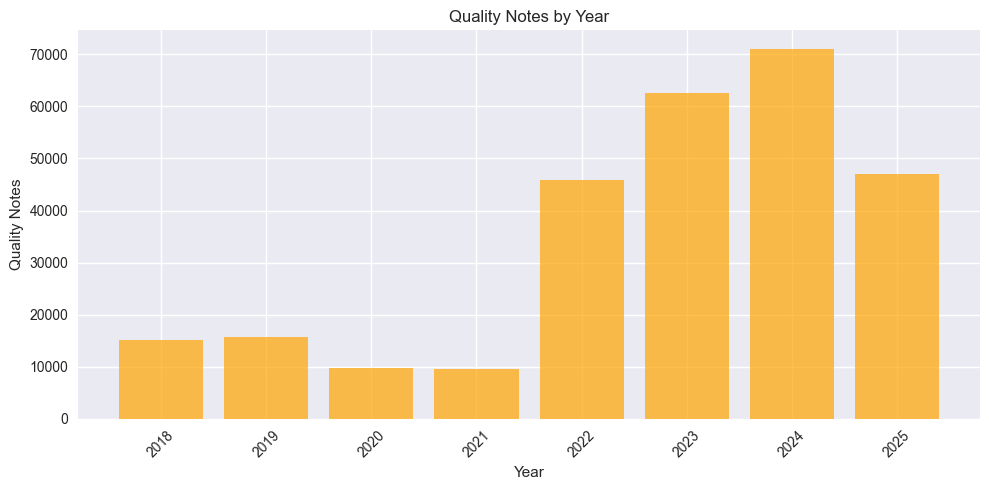

In [8]:
def analyse_temporal_patterns():
    "Brief analysis of temporal patterns in data quality"
    
    print("\nTEMPORAL PATTERNS ANALYSIS:")
    
    # Annual distribution of quality notes
    temporal_analysis = detailed_quality_df.groupby('year').agg({
        'detailed_score': ['count', 'mean'],
        'country': lambda x: x.nunique()
    }).round(1)
    
    temporal_analysis.columns = ['Quality_Notes', 'Avg_Score', 'Countries']
    
    print("Annual Quality Patterns:")
    print(temporal_analysis.to_string(formatters={
        'Quality_Notes': '{:,}'.format,
        'Avg_Score': '{:.1f}'.format,
        'Countries': '{:.0f}'.format
    }))
    
    # Identify peak periods
    peak_year = temporal_analysis['Quality_Notes'].idxmax()
    peak_count = temporal_analysis.loc[peak_year, 'Quality_Notes']
    
    print(f"\nTemporal Insights:")
    print(f"Peak year: {peak_year} ({peak_count:,} quality notes)")
    print(f"Recent trend: {'Increasing' if temporal_analysis['Quality_Notes'].iloc[-1] > temporal_analysis['Quality_Notes'].iloc[-3] else 'Stable/Decreasing'}")
    
    plt.figure(figsize=(10, 5))
    years = temporal_analysis.index
    plt.bar(years, temporal_analysis['Quality_Notes'], alpha=0.7, color='orange')
    plt.xlabel('Year')
    plt.ylabel('Quality Notes')
    plt.title('Quality Notes by Year')
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()
    
    return temporal_analysis

temporal_patterns = analyse_temporal_patterns()

### Research Feasibility Assessment

Bringing together all my analysis to determine whether this dataset can support my research objectives.

**Dataset overview:**
- **Total events**: 309,974 Eastern European conflict events
- **Geographic coverage**: 13 countries across 3 regional groups
- **Quality data available**: 276,856 notes passing basic filters (89.3% pass rate)
- **High-quality subset**: 218,050 notes scoring ≥6/10 (78.8% of quality notes)

**Key findings:**
1. **Data abundance**: Far more quality data than needed for typical research projects
2. **Geographic concentration**: Ukraine dominates (78.6%), providing both opportunities and analytical challenges
3. **Consistent quality**: Average scores range from 6.3-7.0 across countries, indicating reliable reporting standards
4. **Temporal coverage**: Strong data across 2018-2025, with peak activity in 2024 (71,030 notes)

**Quality highlights:**
- **Average detailed score**: 6.4/10 across all countries
- **Minimum score threshold**: No notes scored below 2/10
- **Ukraine performance**: 239,536 quality notes with 98.0% pass rate
- **Russia performance**: 31,716 quality notes with 81.0% pass rate, highest average score (7.0/10)

**Research target feasibility:**
- **1,000 samples**: Achievable (27,686% coverage)
- **5,000 samples**: Achievable (5,537% coverage)  
- **10,000 samples**: Achievable (2,769% coverage)

**Research recommendations:**
Given the abundance of high-quality data, I can afford to be selective and strategic:

1. **For balanced analysis**: Implement country quotas to ensure representation across all 13 countries
2. **For Ukraine-focused research**: Leverage the wealth of Ukrainian data (239,536 quality notes)
3. **For temporal analysis**: Focus on 2022-2024 for peak data density (179,526 total notes)
4. **For methodology**: Use quality scores (6.4/10 average) to prioritise the best examples

**Bottom line**: This dataset is more than sufficient for my research needs. With 218,050 high-quality notes available, the main challenge will be managing the geographic imbalance strategically, not finding enough quality data. The 78.8% high-quality rate provides exceptional confidence in data reliability for extraction model development.

In [9]:
def generate_final_summary():
    
    print("\nFINAL ANALYSIS SUMMARY:\n")
    
    # Key metrics
    total_events = len(eastern_europe_df)
    total_countries = eastern_europe_df['country'].nunique()
    basic_quality_count = notes_quality_df['basic_quality'].sum()
    detailed_quality_count = len(detailed_quality_df)
    high_quality_count = len(detailed_quality_df[detailed_quality_df['detailed_score'] >= 6])
    
    print("Dataset Summary:")
    print(f"Total Eastern European events: {total_events:,}")
    print(f"Countries represented: {total_countries}")
    print(f"Events with notes: {len(notes_quality_df):,}")
    print(f"Basic quality notes: {basic_quality_count:,}")
    print(f"Detailed assessment completed: {detailed_quality_count:,}")
    print(f"High-quality notes (score ≥6): {high_quality_count:,}")
    
    # Geographic insights
    dominant_country = country_distribution.iloc[0]
    best_quality_country = country_quality_stats.iloc[0]
    
    print(f"\nKey Findings:")
    print(f"Dominant country: {dominant_country.name} ({dominant_country['Total_Events']:,} events)")
    print(f"Best quality source: {best_quality_country.name} ({best_quality_country['Quality_Notes']:,.0f} quality notes)")
    print(f"Geographic concentration: {dominant_country['Total_Events']/total_events*100:.1f}% from top country")

generate_final_summary()


FINAL ANALYSIS SUMMARY:

Dataset Summary:
Total Eastern European events: 309,974
Countries represented: 13
Events with notes: 309,974
Basic quality notes: 276,856
Detailed assessment completed: 276,856
High-quality notes (score ≥6): 218,050

Key Findings:
Dominant country: Ukraine (243,794 events)
Best quality source: Ukraine (239,536 quality notes)
Geographic concentration: 78.6% from top country
